<a href="https://colab.research.google.com/github/SrishtiSharma645/glucosense-/blob/main/ml_glucosense.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#import libraries

In [ ]:
!pip install scikit-learn==1.5.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
!pip install scikit-learn==1.5.2
!pip install scikeras[tensorflow]

In [ ]:
!pip install imblearn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold , train_test_split
from scipy.stats import randint, uniform
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score , make_scorer, f1_score,precision_score, recall_score
from sklearn.neural_network import MLPClassifier

#load data

In [ ]:
X = pd.read_csv("/content/drive/MyDrive/ML/reg_features.csv")
y = pd.read_csv("/content/drive/MyDrive/ML/reg_labels.csv")

#classification rules

In [ ]:
def classify_bgl(value):
    if value < 140:
        return 0
    elif value <= 199:
        return 1
    else:
        return 2

y['BGL'] = y['BGL'].apply(classify_bgl)

# train test split with stratification

Stratification ensures that the proportion of classes in the y remains the same in both training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y['BGL'],
    test_size=0.2,
    random_state=2,
    stratify=y['BGL']
)

#scaling

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert scaled arrays back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=10)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)

import numpy as np
print(np.bincount(y_train))


[256 256 256]


#SVM


###initialize model

In [ ]:
svm_model = SVC(probability=True, random_state=2)

###hyperparameter space

In [ ]:
# 7. Define hyperparameter space
param_dist = {
    'C': uniform(0.1, 10),                          # Regularization strength
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], # Kernel types
    'gamma': ['scale', 'auto'],                     # Kernel coefficient
    'degree': [2, 3, 4]                             # Only relevant for 'poly' kernel
}

###stratified 5 fold

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)


###randomized search

In [ ]:
random_search = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1_weighted',
    verbose=2,
    random_state=2,
    n_jobs=-1
)

###fit on training data

In [ ]:
# 10. Fit model
random_search.fit(X_train_scaled, y_train)
best_svm = random_search.best_estimator_



Fitting 5 folds for each of 20 candidates, totalling 100 fits


### predict on test data

In [ ]:
y_pred = best_svm.predict(X_test_scaled)

###model accuracy

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy, 4))

# 2. Precision, Recall, F1 Score (weighted handles class imbalance better)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1 Score:", round(f1, 4))

# 3. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 4. Classification Report
print("\nClassification Report:")
report = classification_report(y_test, y_pred, digits=4)
print(report)


Accuracy: 0.7619
Precision: 0.7671
Recall: 0.7619
F1 Score: 0.7636

Confusion Matrix:
[[56  7  2]
 [ 4 13  4]
 [ 4  4 11]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8750    0.8615    0.8682        65
           1     0.5417    0.6190    0.5778        21
           2     0.6471    0.5789    0.6111        19

    accuracy                         0.7619       105
   macro avg     0.6879    0.6865    0.6857       105
weighted avg     0.7671    0.7619    0.7636       105



#MLP

###initialize the model

In [ ]:
# 1. Define base model
mlp = MLPClassifier(
    hidden_layer_sizes=(200,100,50),   # Three hidden layers
    activation='relu',
    solver='adam',         #adam is optimizer for updating wt
    max_iter=500,          #epoch
    random_state=2)


###  hyperparameter space

In [ ]:
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),  # regularization
    'learning_rate': ['constant', 'adaptive']
}

### Stratified 5-fold CV

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

###randomized search

In [ ]:
random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=20,
    cv=cv,
    scoring='f1_weighted',
    verbose=2,
    random_state=2,
    n_jobs=-1
)

### Fit on training data

In [ ]:
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2, shuffle=True),
                   estimator=MLPClassifier(hidden_layer_sizes=(200, 100, 50),
                                           max_iter=500, random_state=2),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x796c91a91c10>,
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (100, 50),
                                                               (128, 64)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam', 'sgd']},
                   random_state=2, scoring='f1_weighted', verbose=2)

###predict on test data

In [ ]:
#  Best model
best_mlp = random_search.best_estimator_

#Predict using best model
y_pred_mlp = best_mlp.predict(X_test_scaled)

###model accuracy

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_mlp)
print("Accuracy:", accuracy)
print("Best Parameters:", random_search.best_params_)
print("\nBest cross-validation accuracy:", random_search.best_score_)

# Precision, Recall, F1 Score — for multiclass, use average='macro' or 'weighted'
# macro -> not consider unbalanced data
#weighted-> consider unbalanced data
precision = precision_score(y_test, y_pred_mlp, average='weighted')
recall = recall_score(y_test, y_pred_mlp, average='weighted')
f1 = f1_score(y_test, y_pred_mlp, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_mlp))

# Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp))


Accuracy: 0.6571428571428571
Best Parameters: {'activation': 'relu', 'alpha': np.float64(0.008622810337286521), 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}

Best cross-validation accuracy: 0.8728569943844008
Precision: 0.682512315270936
Recall: 0.6571428571428571
F1 Score: 0.666014047895581

Confusion Matrix:
[[49  9  7]
 [ 3 13  5]
 [ 6  6  7]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.75      0.80        65
           1       0.46      0.62      0.53        21
           2       0.37      0.37      0.37        19

    accuracy                           0.66       105
   macro avg       0.56      0.58      0.57       105
weighted avg       0.68      0.66      0.67       105



# CNN

###import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

###reshaping

In [ ]:
'''# Reshape tabular data into 3D input for Conv1D
X_train_cnn = X_train_scaled.values.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.values.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)'''
# Reshape inputs for Conv1D
X_train_cnn = X_train_scaled.values.reshape(-1, X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.values.reshape(-1, X_test_scaled.shape[1], 1)

# Ensure labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

###initialize the model

In [ ]:
'''model = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(3, activation='softmax')  # 3 output classes
])'''

model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(32, 3, activation='relu'),
    GlobalAveragePooling1D(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(3, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


###compile the model

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=8e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

###early stopping and learning rate

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)

###training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight='balanced',
                               classes=np.unique(y_train),
                               y=y_train)
class_weights = dict(enumerate(weights))
print(class_weights)

{0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


In [ ]:
# Fit the model
history = model.fit(
    X_train_cnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    class_weight=class_weights,
    # callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.3581 - loss: 1.1223 - val_accuracy: 0.2095 - val_loss: 1.1044
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4059 - loss: 1.0755 - val_accuracy: 0.6286 - val_loss: 1.0873
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4823 - loss: 1.0513 - val_accuracy: 0.6190 - val_loss: 1.0638
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4823 - loss: 1.0227 - val_accuracy: 0.6190 - val_loss: 1.0159
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5374 - loss: 0.9787 - val_accuracy: 0.6190 - val_loss: 0.9952
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5552 - loss: 0.9705 - val_accuracy: 0.6190 - val_loss: 0.9636
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5386 - loss: 0.9693 - val_accuracy: 0.6190 - val_loss: 0.9389
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5491 - loss: 0.9787 - val_accuracy: 0.

###prediction and evaluation

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Test Accuracy: 70.48 %
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        65
           1       0.43      0.43      0.43        21
           2       0.44      0.63      0.52        19

    accuracy                           0.70       105
   macro avg       0.60      0.63      0.61       105
weighted avg       0.74      0.70      0.72       105

Confusion Matrix:
[[53  6  6]
 [ 3  9  9]
 [ 1  6 12]]


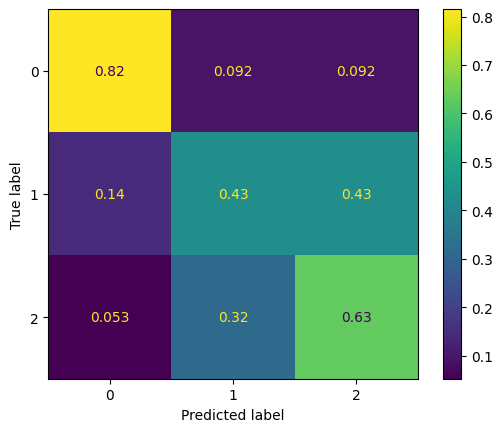

In [ ]:
# Make predictions
y_pred_probs = model.predict(X_test_cnn)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Evaluate model performance on the test set
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print("Test Accuracy:", round(test_accuracy * 100, 2), "%")

# Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_labels))

# Display normalized confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_labels, normalize='true')